# DAS Denoising

#### Qibin Shi, 2024-11-05, at University of Washington, Seattle

### Essential modules

In [1]:
## denoiser source code
import sys
sys.path.append('../src/denoiser/')    
from das_util import *
from denodas_model import unet

### seismic data processing
from obspy import read_events  
from obspy.core import UTCDateTime

### basic data processing
import numpy as np
import torch
import torch.nn as nn

### advanced signal processing
import scipy.signal as sgn
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d

### for saving the data
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import h5py
import pandas as pd   ## for data saving

### for visualization
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

### other fancy stuff
from tqdm import tqdm

### Work directory

In [6]:
### Define data directory
ooi_dir = '/1-fnp/petasaur/p-wd02/muxDAS/20240510/dphi/'

### Define output directory
output_dir = '/home/qibins/denoiser_output/'

os.makedirs(output_dir, exist_ok=True)

### DAS data acquisition parameters

#### Example: OptoDAS interrogator for OOI data

In [7]:
gl, t0, dt, fs, dx, un, ns, nx = extract_metadata(os.path.join(ooi_dir,'000005.hdf5'), machine_name='optodas')
t0 = UTCDateTime(t0)
print('Gauge length (m):\t\t', gl)
print('Start time:\t\t\t', t0)
print('Sample interval (s):\t\t',dt)
print('Sampling rate (Hz):\t\t',fs)
print('Channel interval (m):\t\t',dx)
print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('Number of samples:\t\t',ns)
print('Number of channels:\t\t',nx)

Gauge length (m):		 40.85200763098726
Start time:			 2024-05-10T00:00:05.302000Z
Sample interval (s):		 0.005
Sampling rate (Hz):		 200.0
Channel interval (m):		 10.213001907746815
Unit:				 rad/(s*m)
Number of samples:		 2000
Number of channels:		 9500


### Read 1-minute DAS data

Text(0, 0.5, 'Channel')

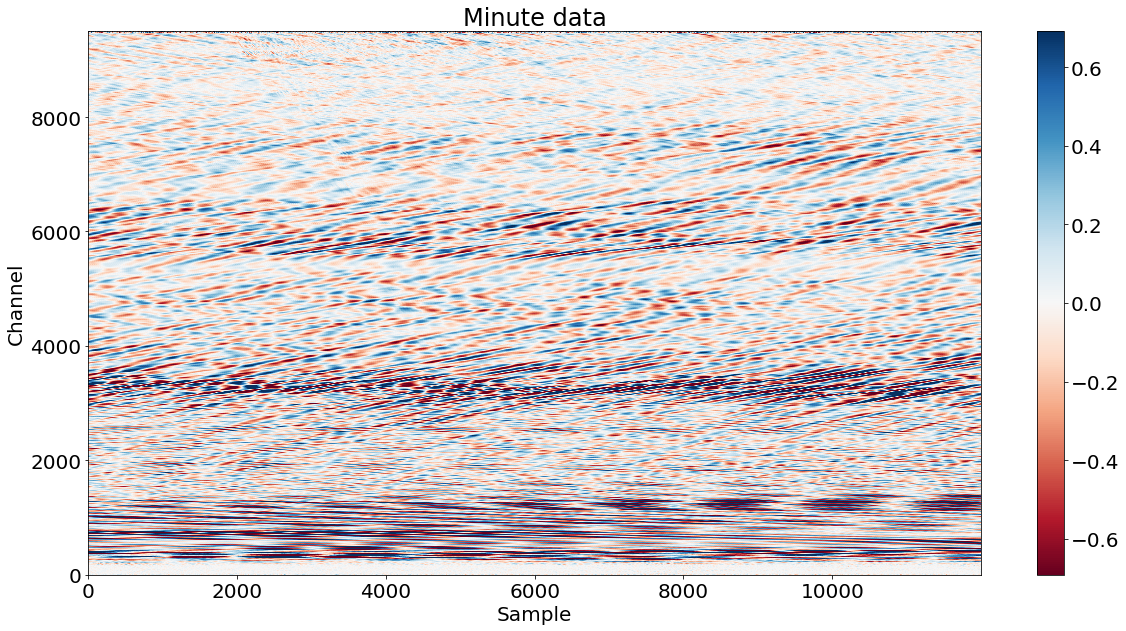

In [16]:
imin = '0249'   ## 02:49
files = ['05.hdf5', '15.hdf5', '25.hdf5', '35.hdf5', '45.hdf5', '55.hdf5']

### Load the data to 'minute_data'
minute_data = np.zeros((nx, int(ns*len(files))), dtype=np.float32)
for k, file in enumerate(files): 
    with h5py.File(ooi_dir + imin + file, 'r') as f:
        time_data =f['data'][:, :]
    st_pt = int(ns * k)

    minute_data[:time_data.shape[1], st_pt:st_pt+time_data.shape[0]] = time_data.T


### Plot the data
plt.figure(figsize=(20, 10))
amp_std = np.std(minute_data)
plt.imshow(minute_data, aspect='auto', cmap='RdBu', vmin=-amp_std/2, vmax=amp_std/2, origin='lower')
plt.colorbar()
plt.title('Minute data')
plt.xlabel('Sample')
plt.ylabel('Channel')

### Decimate the data for denoising, especially for time axis (1500 samples)

Text(0, 0.5, 'Channel')

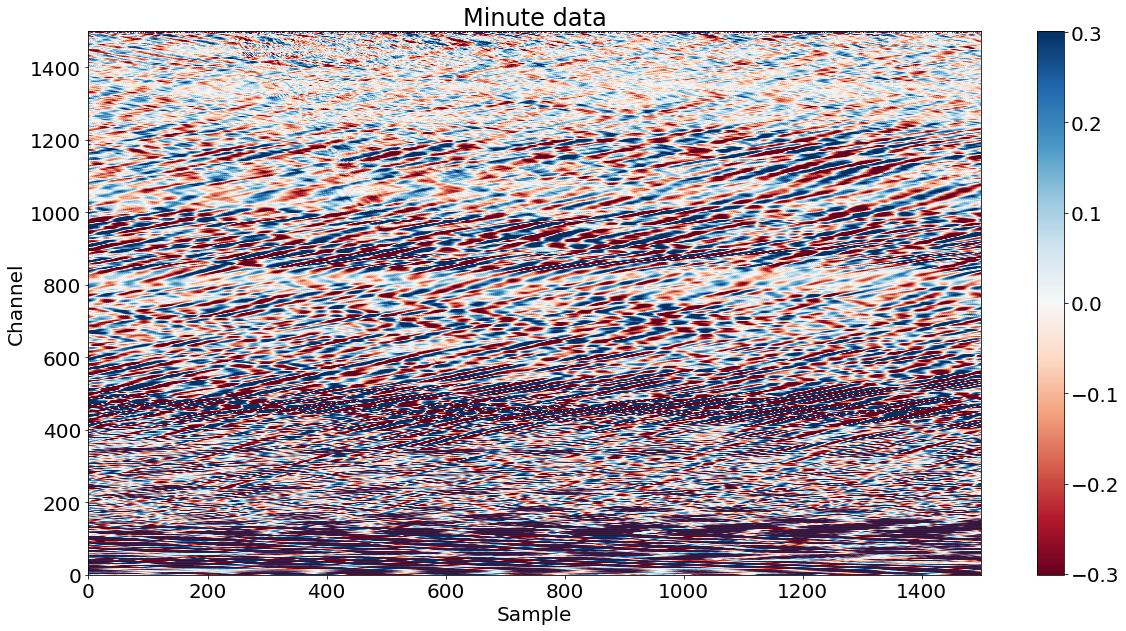

In [32]:
good_data = minute_data[500:9500]   ### discard the beginning channels
tmp = decimate(good_data,int(good_data.shape[1]/1500))   ### Time axis
tmp = decimate(tmp,6, axis=0)   ### Channel axis, here we use 6 times

### Plot the data
plt.figure(figsize=(20, 10))
amp_std = np.std(tmp)
plt.imshow(tmp, aspect='auto', cmap='RdBu', vmin=-amp_std/2, vmax=amp_std/2, origin='lower')
plt.colorbar()
plt.title('Minute data')
plt.xlabel('Sample')
plt.ylabel('Channel')

### Band-pass filter the data

Text(0, 0.5, 'Channel')

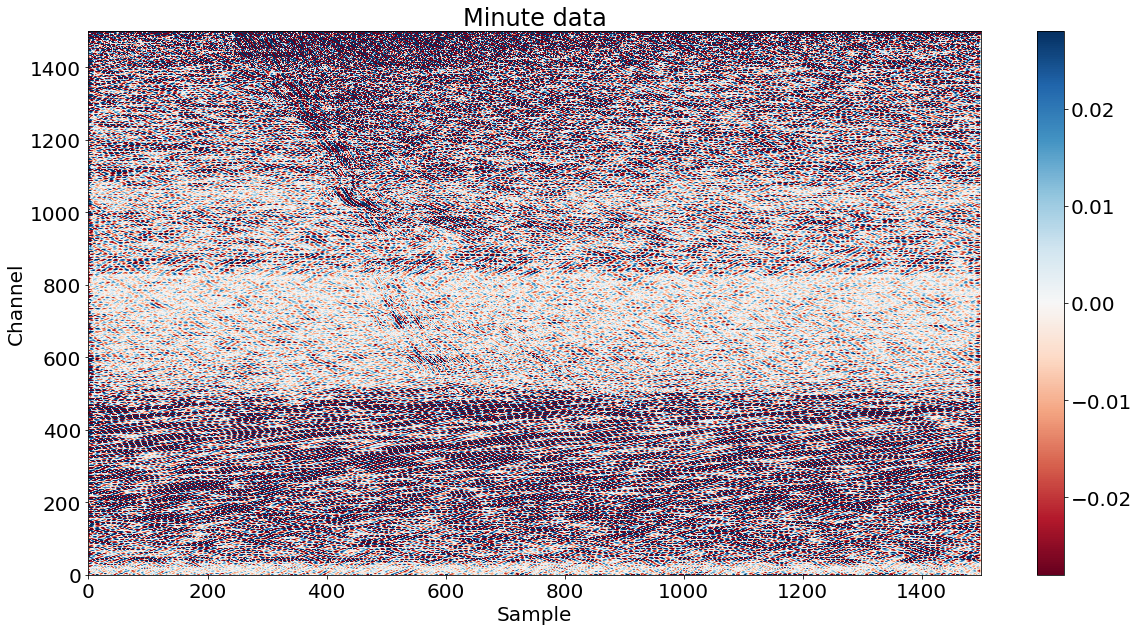

In [33]:
b, a = butter(4, (1, 6), fs=25, btype='bandpass')   ### design the bandpass filter
filt = filtfilt(b, a, tmp, axis=1)   ### apply the bandpass filter
rawdata = filt - np.mean(filt, axis=(0,1), keepdims=True)   ### remove the mean

### Plot the data
plt.figure(figsize=(20, 10))
amp_std = np.std(rawdata)
plt.imshow(rawdata, aspect='auto', cmap='RdBu', vmin=-amp_std/2, vmax=amp_std/2, origin='lower')
plt.colorbar()
plt.title('Minute data')
plt.xlabel('Sample')
plt.ylabel('Channel')

### Denoise

In [34]:
### Initialize the U-net
devc = try_gpu(i=0)
model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[0,1])
model_1.to(devc)

### Load the pretrained weights
model_1.load_state_dict(torch.load('../models/mlmodel/denoiser_weights_LR08_MASK05_raw2raw_old.pt'))
model_1.eval() 

### Using the function 'Denoise_largeDAS'
_, denoised = Denoise_largeDAS(rawdata/np.std(filt, axis=(0,1), keepdims=True), 
                                                model_1, devc, repeat=4, norm_batch=False)


### channel-wise denoising
denoised = (denoised-np.mean(denoised, axis=1, keepdims=True)) * np.std(denoised, axis=1, keepdims=True)

### Bandpass filter
b, a = butter(4, (1, 6), fs=25, btype='bandpass')
filt = filtfilt(b, a, denoised, axis=1)
mul_denoised = filt - np.mean(filt, axis=(0,1), keepdims=True)


torch.Size([1, 1500, 1500])


Text(0, 0.5, 'Channel')

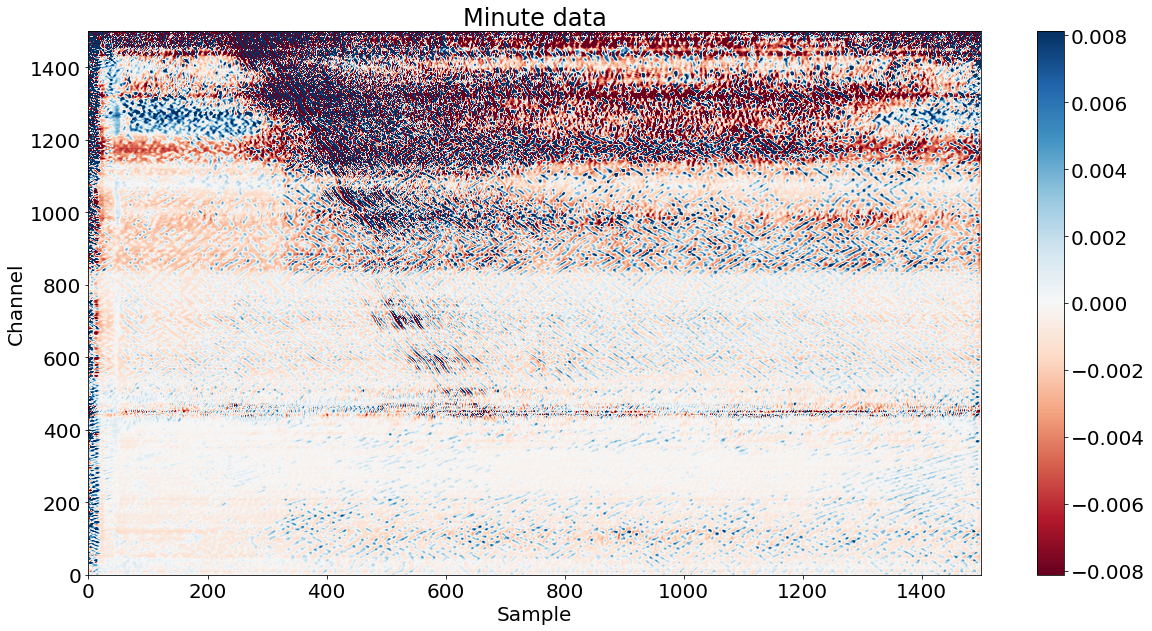

In [35]:
### Plot the data
plt.figure(figsize=(20, 10))
amp_std = np.std(denoised)
plt.imshow(denoised, aspect='auto', cmap='RdBu', vmin=-amp_std/2, vmax=amp_std/2, origin='lower')
plt.colorbar()
plt.title('Minute data')
plt.xlabel('Sample')
plt.ylabel('Channel')

In [ ]:
### plotting the FK 
f0, k0, fk_raw = fk_transform(rawdata.T, 1./25, dx*6)
amps = np.log10(np.abs(fk_raw)).flatten()
q1=np.percentile(amps, q=70)
q2=np.percentile(amps, q=99)
im=ax[1,0].pcolor(k0,f0,np.log10(np.abs(fk_raw)), cmap='viridis', vmax=q2, vmin=q1, rasterized=True, shading='auto')
ax[1,0].set_xlim(-0.004, 0.004)
ax[1,0].set_ylim(0,8)
ax[1,0].set_xlabel("Wavenumber (1/m)", fontsize=20)
ax[1,0].set_ylabel("Frequency(Hz)", fontsize=20)
fig.colorbar(im, ax=ax[1,0],aspect=40, label='dB rel. strain rate (1 / s)')

f0, k0, fk_deno = fk_transform(mul_denoised.T, 1./25, dx*6)
amps = np.log10(np.abs(fk_deno)).flatten()
q1=np.percentile(amps, q=90)
q2=np.percentile(amps, q=99.5)
im=ax[1,1].pcolor(k0,f0,np.log10(np.abs(fk_deno)), cmap='viridis', vmax=q2, vmin=q1, rasterized=True, shading='auto')
ax[1,1].set_xlim(-0.004,0.004)
ax[1,1].set_ylim(0,8)
ax[1,1].set_xlabel("Wavenumber (1/m)", fontsize=20)
ax[1,1].set_ylabel("Frequency(Hz)", fontsize=20)
fig.colorbar(im, ax=ax[1,1],aspect=40, label='dB rel. strain rate (1 / s)')



### plotting the space-time
t_ax = np.arange(mul_denoised.shape[1])/25+8+5
d_ax = ((np.arange(1000)+500)*6+500)*dx/1000-1.860

im=ax[0,0].pcolor(t_ax, d_ax, rawdata*1e9, cmap='RdBu', 
                  vmin=-np.std(rawdata)*4e9, vmax=np.std(rawdata)*4e9, 
                  shading='auto', rasterized=True)

ax[0,0].set_xlabel('time (s)')
ax[0,0].set_ylabel('distance (km)')
ax[0,0].set_title('Raw data '+imin[:4]+'-'+imin[4:6]+'-'+imin[6:8]+' '+imin[-4:-2]+':'+imin[-2:], fontsize=24)
fig.colorbar(im, ax=ax[0,0],aspect=40, label='strain rate (10$^{-9}$ / s)')

ind_good = np.where(raw_picks[:,1,1]>0.07)[0]
print("number of good picks on raw data: ",len(ind_good))
ax[0,0].scatter(raw_picks[ind_good,1,0]+5, d_ax[ind_good] ,c='g', marker='x', alpha=0.5)



im = ax[0,1].pcolor(t_ax, d_ax, mul_denoised*1e9, cmap='RdBu', 
                    vmin=-np.std(mul_denoised)*4e9, vmax=np.std(mul_denoised)*4e9, 
                    shading='auto', rasterized=True)   

ax[0,1].set_xlabel('time (s)')
ax[0,1].set_ylabel('distance (km)')
ax[0,1].set_title('Denoised data '+imin[:4]+'-'+imin[4:6]+'-'+imin[6:8]+' '+imin[-4:-2]+':'+imin[-2:], fontsize=24)
fig.colorbar(im, ax=ax[0,1],aspect=40, label='strain rate (10$^{-9}$ / s)')

ind_good = np.where(mul_picks[:,1,1]>0.07)[0]
print("number of good picks after denoising: ",len(ind_good))
ax[0,1].scatter(mul_picks[ind_good,1,0]+5, d_ax[ind_good], c='g', marker='x', alpha=0.5)

